# トークトリアル 6

# 最大共通部分構造（Maximum common substructure）

#### Developed in the CADD seminars 2017 and 2018, AG Volkamer, Charité/FU Berlin 

Oliver Nagel

## このトークトリアルの目的

サイズの大きい化学データのクラスタリングとクラス分類は、医薬品探索の化学を利用する広範な領域において、研究を導き、分析し、知識を発見することにとって不可欠です。

一つ前のトークトリアルで、化合物をグループ化する方法（クラスタリング）を学び、一つのクラスターに含まれる化合物がお互いに似通っており、共通の骨格（scaffold）を共有していることを見つけました。視覚的に調べることに加えて、ここでは化合物セットが共通してもつ最大の部分構造を計算する方法を学びます。

## 学習の目標

* 最大共通部分構造とは何か（Maximum Common Substructure、MCS）?
* 化合物のグループのMCSを計算するにはどうすれば良いか？

### 理論

* 化合物セットの最大共通部分構造をみつけることについての導入
* FMCSアルゴリズムの詳細な説明

### 実践

* 化合物セットへのFMCSアルゴリズムの適用（**トークトリアル5**で取得したクラスターあるいは**トークトリアル1**で取得したEGFR化合物）
* インタラクティブなカットオフの適用によるMCSの同定

## レファレンス

* Dalke A, Hastings J., FMCS: a novel algorithm for the multiple MCS problem. [*J. Cheminf.* 2013; 5(Suppl 1): O6](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3606201/)
* Raymond JW., Willet P., Maximum common subgraph isomorphism algorithms for the matching of chemical structures. [*J Comput Aided Mol Des.* 2002 Jul;16(7):521-33](https://link.springer.com/article/10.1023/A:1021271615909)
* アルゴリズムに関する情報の書かれたDalkeのWebサイト： http://dalkescientific.com/writings/diary/archive/2012/05/12/mcs_background.html
* MCSに関するRDKitクックブックのドキュメンテーション: http://www.rdkit.org/docs/Cookbook.html#using-custom-mcs-atom-types 

_____________________________________________________________________________________________________________________


## 理論

### 導入

<img src="./images/mymols.png" width="300" align='right'>

最大共通部分構造（maximum common structure、MCS）は２つあるいはそれ以上の対象化合物に含まれる最大の部分構造として定義されています。
* MCSをみつけること　= グラフ内の最大共通パターンマッチング問題（maximum common subgraph isomorphism problem）
* ケモインフォマティクスの分野で多くの適用用途があります。類似性検索（similarity search）、階層クラスタリング（hierarchical clustering）、分子アラインメント（molecule alignment）
* 利点：
 * 直観的 $\rightarrow$ 対象化合物に共有されている構造は重要である可能性が高い
 * ありうる活性のパターンへの洞察を与える
 * 単純に部分構造をハイライトすることで簡単に可視化できる

MCSアルゴリズムの詳細 (レビューを参照してください: [*J Comput Aided Mol Des.* 2002 Jul;16(7):521-33](https://link.springer.com/article/10.1023/A:1021271615909))
* 2つあるいはそれ以上のグラフ間のMCSを決めることはNP-完全問題です。
* 厳密に決定するためのアルゴリズムと近似アルゴリズムのどちらもあります。
    * 厳密：最大クリーク（Maximum-clique）、後戻り法（バックトラック法、backtracking）、動的計画法（dynamic programming）
    * 近似：遺伝的アルゴリズム（Genetic algorithm）、組合せ最適化（combinatorial optimization）、フラグメントストレージ（fragment storage）、・・・ 
    * 問題分割：分子グラフの単純化

[FMCS](http://dalkescientific.com/writings/diary/archive/2012/05/12/mcs_background.html) アルゴリズム：
* MCS問題をグラフパターンマッチング問題（graph isomorphism problem）としてモデル化します。
* サブグラフの数え上げとサブグラフのパターンマッチングテスト（subgraph isomorphism testing）に基づきます。

### FMCSアルゴリズムの詳細な説明
[*J. Cheminf.* 2013; 5(Suppl 1): O6](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3606201/) と[rdkit fmcs documentaion](http://www.rdkit.org/docs/source/rdkit.Chem.fmcs-fmcs.html)　の各項目で説明されています。

#### 単純化したアルゴリズムの説明

```
best_substructure = None
pick one structure in the set as query, all other as targets    # 化合物セットから一つをクエリとして選び、残り全てをターゲットにする
for each substructure in the query:    # クエリの各部分構造について
    convert into a SMARTS string based on the desired match properties    # マッチングを希望する特徴に基づきSMARTS文字列に変換する 
    if SMARTS pattern exists in all of the targets:    # もしターゲットのすべてにそのSMARTSパターンが存在していれば
    then it is a common substructure    # それが共通部分構造となります
        keep track of the maximum of such substructure    # そのような部分構造の最大となるものを順に辿っていきます。
```

通常、この単純なアプローチだけではとても長い時間がかかりますが、実行時間を加速するためのトリックがいくつかあります。

#### 結合除去（Bond elimination）
<img src="./images/transition.png" width="350" align='right'>

* MCSの部分とはなり得ない結合の除去
* 各入力構造に原子タイプと結合タイプの情報が存在している必要があります
* 結合タイプ：最初の原子、結合、２つめの原子のSMATSからなる文字列
* 入力構造全てに存在していない全ての結合タイプを排除し、それぞれの辺（edge）を削除
* 結果：全ての原子の情報をもちつつ、辺（edge（結合))の数がより少ないフラグメント化された構造

#### 最大フラグメントのうち最小の構造をクエリとして用いる

<img src="./images/query.png" width="150" align='right'>

* ヒューリスティックなアプローチ：
    * 各入力構造の最大のフラグメントを見つける
    * 最大フラグメントの結合の数によって入力構造を昇順に並べ換える
    * 原子の数との紐付けを解き、入力の順を代わりのものとして使う  
* 最大フラグメントのうち最小の構造をクエリ構造とする
* 他の入力構造由来の構造がターゲットとなります


#### フラグメントのサブグラフを列挙するために、幅優先探索（breadth-first search (BFS)）と優先度付きキュー（priority que）を使う

<img src="./images/seeds.png" width="150" align='right'>

* いわゆる種（シード、seed)を成長させることに基づく列挙（enumeration）
* シード：現在のサブグラフの原子/結合と、除外するセット（成長には使えない結合）
* 冗長性を防ぐために：
    * 最初のシードはフラグメントの最初の結合で、フラグメント全体のサイズにまで成長する可能性があります
    * ２番目のシードは２番目の結合で、最初の結合を使ったものからは排除されます
    * ３番目のシードは３番目の結合から始まり、最初と２番目を使用したものからは排除されます
    * ・・・
* シードはシードにつながっている結合に沿って成長します（除外セットや既にシードに含まれているものは含みません）
* 各ステップですべての成長の可能性が考慮されます
* 例、拡張の方向としてN個の可能な結合がある時、$2^{N-1}$個の新しいシードがキューにつけ加えられる

<img src="./images/growing.png" width="350" align='right'>

* サブグラフに加える新しい結合がなくなった時点で列挙は終わります（シードがキューから除外されます）
* 最大のシードが最初に処理されます

#### 他の全ての構造に含まれていないシードを取り除く

* 各成長の段階で $\rightarrow$ 新しいシードが他の全ての構造に存在しているかどうかチェックする　　
* 存在していない場合：キューからシードを取り除く

#### 十分な成長のポテンシャルがないシードを取り除く

* 除外リストと拡張の可能性がある辺（エッジ）から成長ポテンシャルを評価します
* 現在の最も良いサブグラフよりもポテンシャルが小さい場合 -> シードをキューから取り除きます

これらのアプローチを使うことで、最大共通部分構造に相当する最大のサブグラフを順に辿っていくことことは普通の問題となります。

## 実践

In [1]:
# 必要なモジュールをインポート
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from collections import defaultdict
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
import pandas as pd
import numpy
from rdkit.Chem import PandasTools
IPythonConsole.ipython_useSVG=True

### 化合物を読み込み描画

Set with 143 molecules loaded


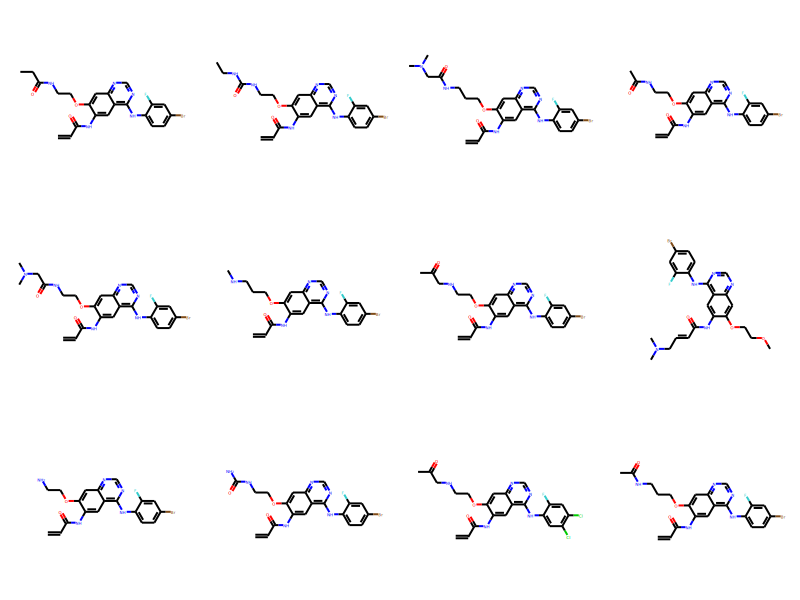

In [2]:
suppl = Chem.SDMolSupplier('../data/T5/molSet_largestCluster.sdf')
mols = [x for x in suppl]
print('Set with %d molecules loaded'%(len(mols)))

# 最初の１２個の化合物を表示
#Draw.MolsToGridImage(mols[:12], legends=[x.GetProp("_Name") for x in mols[:12]], molsPerRow=4)
Draw.MolsToGridImage(mols[:12], molsPerRow=4)

### 様々なパラメーター入力値でRDKitに実装されているFMCSアルゴリズムを実行
#### デフォルト値

最も単純な場合、化合物のリストだけをパラメーターとして与えます。

SMARTS string: [#6]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]-[#6]


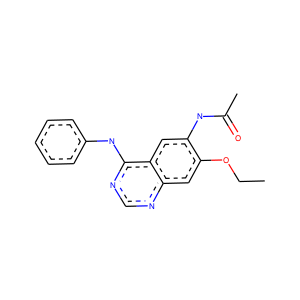

In [3]:
mcs1 = rdFMCS.FindMCS(mols)
print('SMARTS string: %s'%mcs1.smartsString)
# 構造の描画
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1)

MCSをハイライトして化合物を描画するためのヘルパー関数を定義します。

In [4]:
# クエリー化合物群のMCSをハイライトします
def highlightMolecules(cur_mols, cur_mcs, num, label=True):
    pattern = Chem.MolFromSmarts(cur_mcs.smartsString)
    matching = [cur_mols[i].GetSubstructMatch(pattern) for i in range(0,len(cur_mols))]
    
    if label==True:
        return Draw.MolsToGridImage(cur_mols[:num], 
                                    legends=[x.GetProp("_Name") for x in mols[:num]], 
                                    molsPerRow=3,
                                    highlightAtomLists = matching[:num],
                                    subImgSize=(300,250))
    else:
        return Draw.MolsToGridImage(cur_mols[:num], 
                                    molsPerRow=3,
                                    highlightAtomLists = matching[:num],
                                    subImgSize=(300,250))

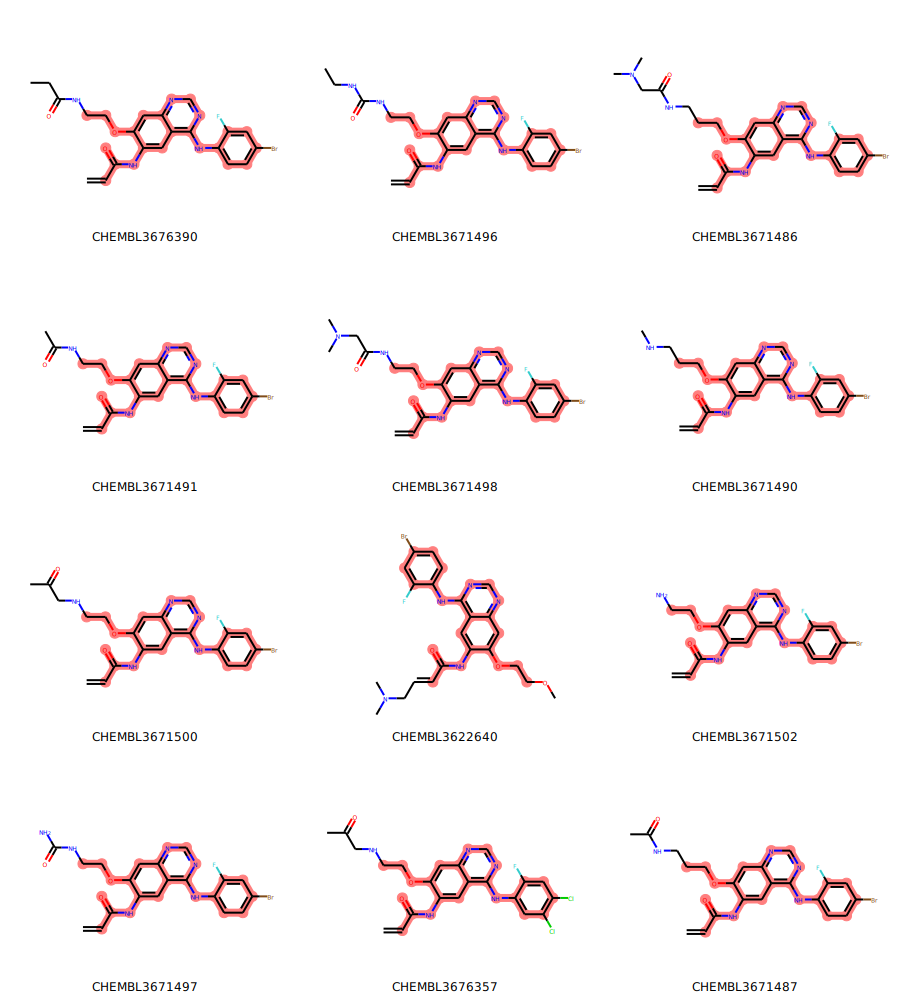

In [5]:
highlightMolecules(mols, mcs1, 12)

In [6]:
img = highlightMolecules(mols, mcs1, 3)

# SVGデータを取得
molsvg = img.data

# 背景を透明に設定
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0");
# ラベルのサイズを大きくする
molsvg = molsvg.replace("12px", "20px")

# 変更したSVGデータを保存する
f = open("../data/T6/mcs_largestcluster.svg", "w")
f.write(molsvg)
f.close()

#### 閾値を設定

部分構造の閾値を下げることも可能で、例えば、MCSが入力構造の80%の化合物にだけあれば良いようにすることもできます。

SMARTS string: [#6]=[#6]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3-[#9]):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]-[#6]-[#7]-[#6]


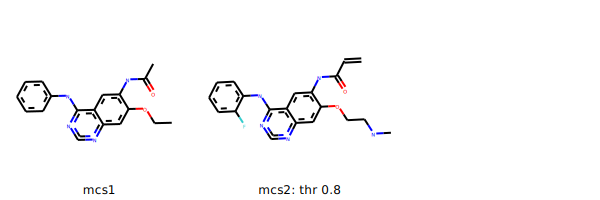

In [7]:
mcs2 = rdFMCS.FindMCS(mols, threshold=0.8)
print('SMARTS string: %s'%mcs2.smartsString)

# 部分構造を描画
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1,m2], legends=['mcs1', 'mcs2: thr 0.8'])

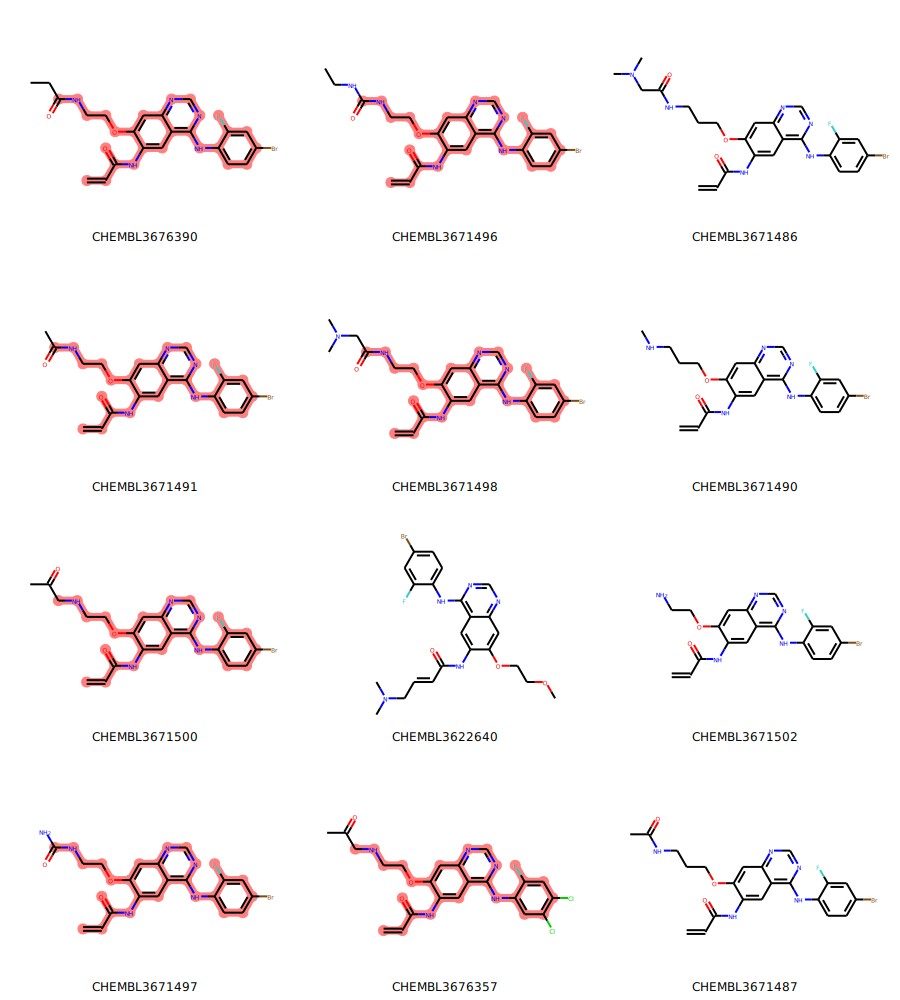

In [8]:
highlightMolecules(mols, mcs2, 12)

この例を見ればわかるように、化合物CHEMBL27685は除外され（閾値 0.8）、その結果、より大きな共通部分構造として、メタ位にフッ素置換したベンゼンとより短いアルキル鎖をもつ部分構造が見つかっています。

**訳注(2020/04）**

今回の実行結果ではオリジナルのノートと異なりCHEMBL27685は上図に含まれません。上図中ではCHEMBL3622640にはMCSが含まれていません。閾値0.8のMCS（mcs2）はエーテル側鎖の先のN原子までを含んでいますが、CHEMBL3622640ではN原子ではなくO原子となっています。MCSの閾値を下げることで、全ての分子には含まれないもののより大きな部分構造をMCSとして見出していることが確認できます。

**訳注ここまで**

#### 環結合（ring bonds）のマッチング

このパラメーターが ```True``` にセットすると、環の結合だけが他の環の結合とマッチングします。

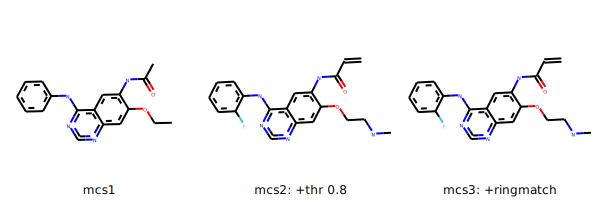

In [8]:
mcs3 = rdFMCS.FindMCS(mols, ringMatchesRingOnly=True, threshold=0.8)
# 部分構造を描画
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1,m2,m3], legends=['mcs1', 'mcs2: +thr 0.8','mcs3: +ringmatch'])

ここでは選択した閾値とパラメーターに依存して、少し異なるMCSが得られています。 [RDKitのFMCSモジュール](http://www.rdkit.org/docs/source/rdkit.Chem.fmcs-fmcs.html)にはもっと多くのパラメーターのオプションが利用可能で、例えば考慮する原子、結合、価数のマッチングといったものがある、ということを注記しておきます。

### さあ、より多様なセットをさっと見てみましょう：ChEMBLからダウンロードしたEGFR化合物群

データを高活性な化合物（pIC50>9）だけに限定し、このサブセットから最大共通骨格を発見しましょう。

(5428, 5)
(191, 5)


,molecule_chembl_id,units,IC50,smiles,pIC50,ROMol
0,CHEMBL63786,nM,0.003,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,
1,CHEMBL53711,nM,0.006,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,
2,CHEMBL35820,nM,0.006,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,

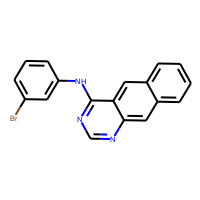
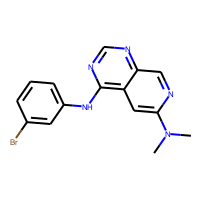
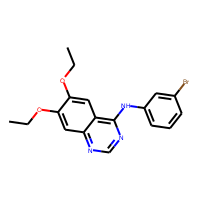

In [9]:
# 全EGFRデータの読み込み
mol_df=pd.read_csv('../data/T1/EGFR_compounds.csv', index_col=0)
print(mol_df.shape)

# pIC50 > 9 (IC50 > 1nM)の化合物のみを保持
mol_df=mol_df[mol_df.pIC50>9]
print(mol_df.shape)

# データフレームに分子を追加
PandasTools.AddMoleculeColumnToFrame(mol_df, 'smiles')
mol_df.head(3)

SMARTS string1: [#6](:,-[#6]:,-[#6]:,-[#6]):,-[#6]:,-[#6]:,-[#7]:,-[#6]
SMARTS string2: [#6]1:[#6]:[#6]:[#6]:[#6](:[#6]:1):,-[#7]:,-[#6]:[#7]:[#6]-,:[#7]-,:[#6](:[#6]:[#6]:[#6]):[#6]
SMARTS string3: [#6]:[#6]:[#6](:[#7]:[#6]:[#7]:[#6]-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1):[#6]


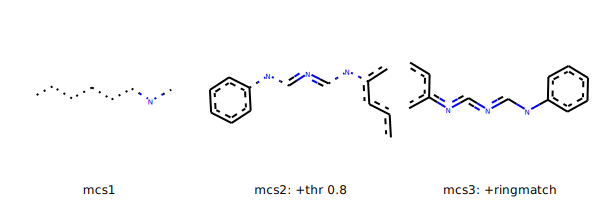

In [10]:
# 選択した高活性化合物だけについて計算を実行します
mols= []
for idx, row in mol_df.iterrows():
    m = Chem.MolFromSmiles(row.smiles)
    m.SetProp("_Name",row.molecule_chembl_id)
    mols.append(m)
# 時間の都合上、このセットから50化合物をランダムに取り出します 
rand_mols = [mols[i] for i in numpy.random.choice(range(len(mols)), size=50)]

mcs1 = rdFMCS.FindMCS(rand_mols)
print('SMARTS string1: %s'%mcs1.smartsString)
mcs2 = rdFMCS.FindMCS(rand_mols, threshold=0.8)
print('SMARTS string2: %s'%mcs2.smartsString)
mcs3 = rdFMCS.FindMCS(rand_mols, ringMatchesRingOnly=True, threshold=0.8)
print('SMARTS string3: %s'%mcs3.smartsString)

# 部分構造を描画
m1 = Chem.MolFromSmarts(mcs1.smartsString)
m2 = Chem.MolFromSmarts(mcs2.smartsString)
m3 = Chem.MolFromSmarts(mcs3.smartsString)

Draw.MolsToGridImage([m1,m2,m3], legends=['mcs1', 'mcs2: +thr 0.8','mcs3: +ringmatch'])

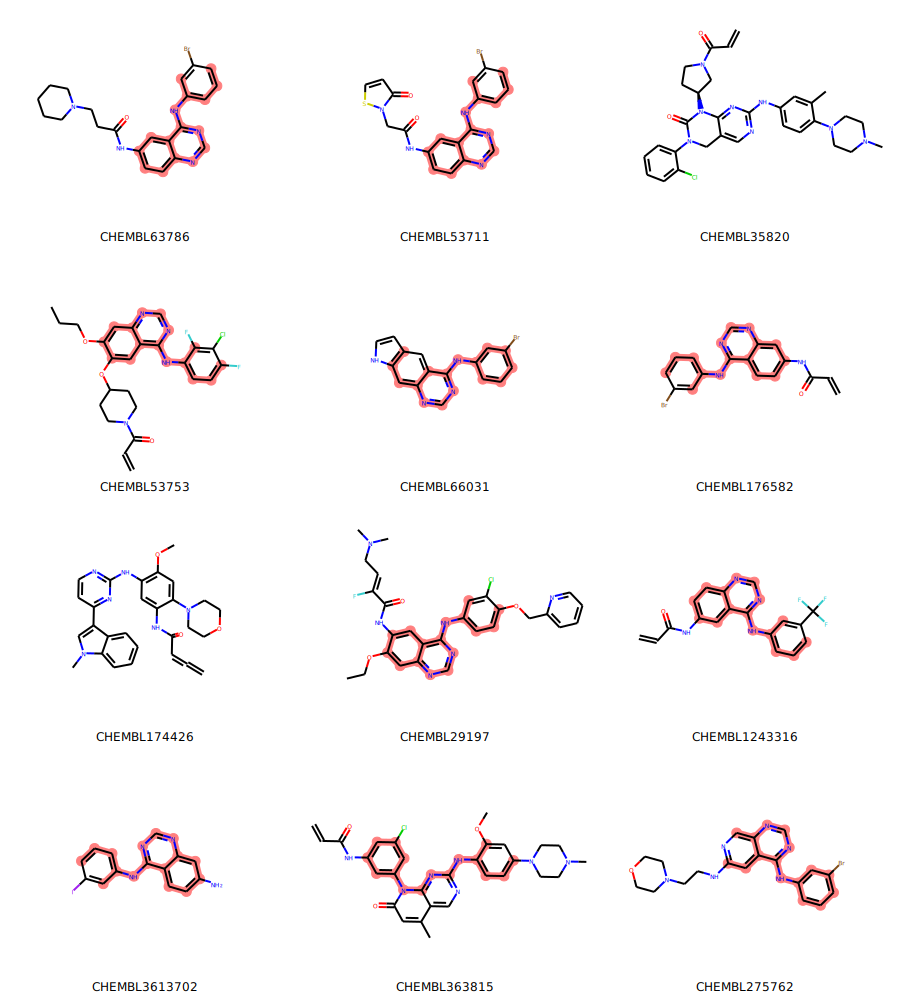

In [11]:
highlightMolecules(rand_mols, mcs2, 12)

閾値をインタラクティブに変更することもできます。

In [12]:
from ipywidgets import interactive, interact, fixed, Text, widgets
from IPython.display import SVG,display

In [13]:
def renderMCS(perc):
    tmcs = rdFMCS.FindMCS(rand_mols, threshold=perc/100.)
    if tmcs is None:
        print('No MCS found')
        return None
    else:
        m = Chem.MolFromSmarts(tmcs.smartsString)
        print(tmcs.smartsString)
        return(display(SVG(IPythonConsole._toSVG(m))))

In [15]:
# スライダーが反応するのに数秒かかるかもしれません
w = interact(renderMCS, perc=widgets.IntSlider(min=0,max=100,step=20,value=80))

interactive(children=(IntSlider(value=80, description='perc', step=20), Output()), _dom_classes=('widget-inter…

## クイズ

* 最大共通部分構造（MCS）の計算が役立つのはなぜでしょう？
* どうすればMCSを計算できるか簡潔に説明できますか？
* EGFR活性化合物の典型的なフラグメントはどのようにみえますか？